In [0]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import networkx as nx
import math
import random

In [2]:
pip install hpbandster

     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 92kB 3.2MB/s 
     |████████████████████████████████| 972kB 4.9MB/s 
  Created wheel for hpbandster: filename=hpbandster-0.7.4-cp36-none-any.whl size=80007 sha256=6d2be387aff2aefd819d0054e44e51a38d9374454e0e65088e2fb1627cf3948e
  Stored in directory: /root/.cache/pip/wheels/9d/57/62/6b00c8011bac96e0c404adc5be4e16964ba4544614240b4e23
  Created wheel for ConfigSpace: filename=ConfigSpace-0.4.13-cp36-cp36m-linux_x86_64.whl size=2914581 sha256=b9f5fc9e85ee6233c6069534edb5e0664b0dc0848acb8139788a0c746ef1194d
  Stored in directory: /root/.cache/pip/wheels/9e/13/67/89f852e4a5cf173e6c7da5e9d449b8e98483bc8168cf7b6e6d
Successfully built hpbandster ConfigSpace


In [0]:
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH

from hpbandster.core.worker import Worker

import logging
logging.basicConfig(level=logging.DEBUG)

In [0]:
class PyTorchWorker(Worker):
    def __init__(self, N_train = 8192, N_valid = 1024, **kwargs):
            super().__init__(**kwargs)

            batch_size = 64

            # Load the MNIST Data here
            train_dataset = torchvision.datasets.MNIST(root='../../data', train=True, transform=transforms.ToTensor(), download=True)
            test_dataset = torchvision.datasets.MNIST(root='../../data', train=False, transform=transforms.ToTensor())

            train_sampler = torch.utils.data.sampler.SubsetRandomSampler(range(N_train))
            validation_sampler = torch.utils.data.sampler.SubsetRandomSampler(range(N_train, N_train+N_valid))


            self.train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
            self.validation_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1024, sampler=validation_sampler)

            self.test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False)


    def compute(self, config, budget, working_directory, *args, **kwargs):
            """
            Simple example for a compute function using a feed forward network.
            It is trained on the MNIST dataset.
            The input parameter "config" (dictionary) contains the sampled configurations passed by the bohb optimizer
            """

            # device = torch.device('cpu')
            model = LeNet()
            criterion = torch.nn.CrossEntropyLoss()
            if config['optimizer'] == 'Adam':
                    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
            else:
                    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['sgd_momentum'])

            for epoch in range(int(budget)):
                    loss = 0
                    model.train()
                    for i, (x, y) in enumerate(self.train_loader):
                            optimizer.zero_grad()
                            output = model(x)
                            loss = F.nll_loss(output, y)
                            loss.backward()
                            optimizer.step()

            train_accuracy = self.evaluate_accuracy(model, self.train_loader)
            validation_accuracy = self.evaluate_accuracy(model, self.validation_loader)
            test_accuracy = self.evaluate_accuracy(model, self.test_loader)

            return ({
                    'loss': 1-validation_accuracy, # remember: HpBandSter always minimizes!
                    'info': {       'test accuracy': test_accuracy,
                                            'train accuracy': train_accuracy,
                                            'validation accuracy': validation_accuracy,
                                            'number of parameters': model.number_of_parameters(),
                                    }

            })

    def evaluate_accuracy(self, model, data_loader):
            model.eval()
            correct=0
            with torch.no_grad():
                    for x, y in data_loader:
                            output = model(x)
                            #test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
                            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                            correct += pred.eq(y.view_as(pred)).sum().item()
            #import pdb; pdb.set_trace()
            accuracy = correct/len(data_loader.sampler)
            return(accuracy)

    @staticmethod
    def get_configspace():
            """
            It builds the configuration space with the needed hyperparameters.
            It is easily possible to implement different types of hyperparameters.
            Beside float-hyperparameters on a log scale, it is also able to handle categorical input parameter.
            :return: ConfigurationsSpace-Object
            """
            cs = CS.ConfigurationSpace()
            
           

            cs.add_hyperparameters([learning_rate])

            return cs

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
    self.conv2 = nn.Conv2d(6, 16, (5,5))
    self.fc1   = nn.Linear(16*5*5, 120)
    self.fc2   = nn.Linear(120, 84)
    self.fc3   = nn.Linear(84, 10)
  
  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

  def number_of_parameters(self):
    return(sum(p.numel() for p in self.parameters() if p.requires_grad))  


Setting up Graph for ACO

In [0]:
class Graph:

    def __init__(self,num_lr):
      self.num_lr = num_lr
      
    
    def generate_graph(self):
      G = nx.DiGraph()        #Directional graph
      edges=[]
      G.add_node('inp')
      G.add_node('out')
      for lr in range(self.num_lr):
        learning_rate = random.uniform(1e-6, 1e-1)
        G.add_node(lr, lr=learning_rate)
        edge = ['inp',lr,1]                     #initial weight is 1 (pheromone value)
        edges.append(edge)
        edge = [lr,'out',1]
        edges.append(edge)
     # for dr in range(self.num_dr):
     #  dropout_rate = random.uniform(0.0, 0.9)
     #  G.add_node(dr+self.num_lr, dr=dropout_rate)
     #  for lr in range(self.num_lr):
     #    edge = [lr,dr+self.num_lr,1]
     #    edges.append(edge)

     # for nfu in range(self.num_num_fc_units): 
     #  num_fc_units = random.randint(8, 256)
     #  G.add_node(nfu+self.num_lr+self.num_dr, nfu=num_fc_units)
     #  edge = [nfu+self.num_lr+self.num_dr,'out',1]
     #  edges.append(edge)
     #  for dr in range(self.num_dr):
     #    edge = [dr+self.num_lr,(nfu+self.num_lr+self.num_dr),1]
     #    edges.append(edge)

      G.add_weighted_edges_from(edges)
    
      return G


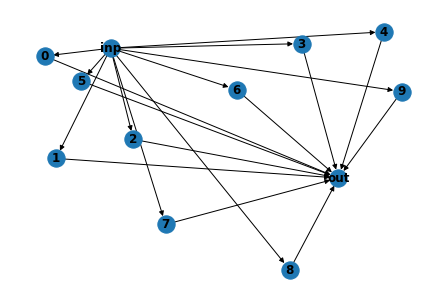

In [13]:
Graphed = Graph(10)
G = Graphed.generate_graph()
nx.draw(G,with_labels=True,font_weight='bold')

In [18]:
list(G.nodes.data())

[('inp', {}),
 ('out', {}),
 (0, {'lr': 0.007106310445211086}),
 (1, {'lr': 0.07894674225623952}),
 (2, {'lr': 0.004876453798339075}),
 (3, {'lr': 0.003713091986089373}),
 (4, {'lr': 0.07498649007048654}),
 (5, {'lr': 0.06084660694002145}),
 (6, {'lr': 0.03989692223134097}),
 (7, {'lr': 0.04471943599099445}),
 (8, {'lr': 0.06976793093546046}),
 (9, {'lr': 0.06653462625167526})]

In [14]:
list(G.edges.data())

[('inp', 0, {'weight': 1}),
 ('inp', 1, {'weight': 1}),
 ('inp', 2, {'weight': 1}),
 ('inp', 3, {'weight': 1}),
 ('inp', 4, {'weight': 1}),
 ('inp', 5, {'weight': 1}),
 ('inp', 6, {'weight': 1}),
 ('inp', 7, {'weight': 1}),
 ('inp', 8, {'weight': 1}),
 ('inp', 9, {'weight': 1}),
 (0, 'out', {'weight': 1}),
 (1, 'out', {'weight': 1}),
 (2, 'out', {'weight': 1}),
 (3, 'out', {'weight': 1}),
 (4, 'out', {'weight': 1}),
 (5, 'out', {'weight': 1}),
 (6, 'out', {'weight': 1}),
 (7, 'out', {'weight': 1}),
 (8, 'out', {'weight': 1}),
 (9, 'out', {'weight': 1})]

In [0]:
class ACO:
    def __init__(self,num_ants,Graph):
         self.num_ants = num_ants
         self.G = Graph

    def generate_ants(self): 
         best_path = []
         best_loss = math.inf
         for i in range(self.num_ants):
        
        
           if(i==0):
             path = self.select_random_path()
             self.local_pheromone_update(path)
             print(path)
             result = self.evaluation(path) 
             if (result['loss'] < best_loss):
              best_path = path
              best_loss = result['loss']
           else:
             path = self.select_aco_path()
             self.local_pheromone_update(path)
             print(path)
             result = self.evaluation(path) 
             if (result['loss'] < best_loss):
              best_path = path
              best_loss = result['loss']
         return best_path

    def select_random_path(self):
        """Randomly selects ant path from source to destination"""
        ant_path = [] 
        current_node = 'inp' 
        ant_path.append(current_node)
        next_node = 'inp'

        while(next_node!='out'):
         next_node = random.choice(list(G.successors(current_node)))
         current_node = next_node
         ant_path.append(next_node)
        
        return ant_path   

    def select_aco_path(self):
        """Selects ant path from source to destination based on ACO select rule"""
        ant_path = []
        current_node = 'inp' 
        ant_path.append(current_node)
        next_node = 'inp'

        while(next_node!='out'):
         next_node = self.aco_select_rule(current_node)
         current_node = next_node
         ant_path.append(next_node)
        
        return ant_path    

    def aco_select_rule(self, current_node):
        """Selects neigbour using ACO transition rule"""
        

        probabilities = []
        denominator = 0.0
        greediness = 0.5
        neighbours = list(G.successors(current_node))
        # Calculate probability for each neighbour    (heuristics are not considered)
        for i in range(len(neighbours)):
            probability = self.G[current_node][neighbours[i]]['weight']    #pheromone value
            probabilities.append(probability)
            denominator += probability

        # Try to perform greedy select: exploitation
        random_variable = random.uniform(0, 1)
        if random_variable <= greediness:
            # Find max probability
            max_probability = max(probabilities)
            # Gather the indices of probabilities that are equal to the max probability
            max_indices = [i for i, j in enumerate(probabilities) if j == max_probability]
            # From those max indices select random index
            neighbour_index = random.choice(max_indices)
            return neighbours[neighbour_index]

        # Otherwise perform select using roulette wheel: exploration
        probabilities = [x / denominator for x in probabilities]
        probability_sum = sum(probabilities)
        random_threshold = random.uniform(0, probability_sum)
        current_value = 0
        for neighbour_index, probability in enumerate(probabilities):
            current_value += probability
            if current_value > random_threshold:
                return neighbours[neighbour_index]

    def local_pheromone_update(self,path):      
        pheromone_0 = 0.1
        decay = 0.1
        for i in range(len(path)-1):
          self.G[path[i]][path[i+1]]['weight'] = (1 - decay) * self.G[path[i]][path[i+1]]['weight'] + (decay * pheromone_0)

    def evaluation(self,path):
       lr = G.nodes[path[1]]['lr']
       config = {
           'lr': lr,
           'optimizer': 'Adam'
       }
       print(config)
       worker = PyTorchWorker(run_id='0')
       res = worker.compute(config=config, budget=10, working_directory='.')
       print(res)
       return res

In [16]:
acs=ACO(10,G)
best_path = acs.generate_ants()
print(best_path)

['inp', 1, 'out']
{'lr': 0.07894674225623952, 'optimizer': 'Adam'}


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw



Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...
Done!




/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


{'loss': 0.904296875, 'info': {'test accuracy': 0.098, 'train accuracy': 0.10009765625, 'validation accuracy': 0.095703125, 'number of parameters': 61706}}
['inp', 9, 'out']
{'lr': 0.06653462625167526, 'optimizer': 'Adam'}
{'loss': 0.888671875, 'info': {'test accuracy': 0.1135, 'train accuracy': 0.1136474609375, 'validation accuracy': 0.111328125, 'number of parameters': 61706}}
['inp', 1, 'out']
{'lr': 0.07894674225623952, 'optimizer': 'Adam'}
{'loss': 0.8984375, 'info': {'test accuracy': 0.1028, 'train accuracy': 0.10693359375, 'validation accuracy': 0.1015625, 'number of parameters': 61706}}
['inp', 5, 'out']
{'lr': 0.06084660694002145, 'optimizer': 'Adam'}
{'loss': 0.888671875, 'info': {'test accuracy': 0.1135, 'train accuracy': 0.1136474609375, 'validation accuracy': 0.111328125, 'number of parameters': 61706}}
['inp', 4, 'out']
{'lr': 0.07498649007048654, 'optimizer': 'Adam'}
{'loss': 0.904296875, 'info': {'test accuracy': 0.098, 'train accuracy': 0.10009765625, 'validation accur

In [17]:
list(G.edges.data())

[('inp', 0, {'weight': 0.91}),
 ('inp', 1, {'weight': 0.8290000000000001}),
 ('inp', 2, {'weight': 1}),
 ('inp', 3, {'weight': 0.91}),
 ('inp', 4, {'weight': 0.91}),
 ('inp', 5, {'weight': 0.91}),
 ('inp', 6, {'weight': 1}),
 ('inp', 7, {'weight': 0.91}),
 ('inp', 8, {'weight': 0.8290000000000001}),
 ('inp', 9, {'weight': 0.91}),
 (0, 'out', {'weight': 0.91}),
 (1, 'out', {'weight': 0.8290000000000001}),
 (2, 'out', {'weight': 1}),
 (3, 'out', {'weight': 0.91}),
 (4, 'out', {'weight': 0.91}),
 (5, 'out', {'weight': 0.91}),
 (6, 'out', {'weight': 1}),
 (7, 'out', {'weight': 0.91}),
 (8, 'out', {'weight': 0.8290000000000001}),
 (9, 'out', {'weight': 0.91})]

In [19]:
print(list(best_path))

['inp', 3, 'out']
